# 第四章　暖冷房設備 / Chapter 4 Heating and cooling equipment

## 第八節　ルームエアコンディショナー付温水床暖房 / Section 8 Hot Water Floor Heating with RAC

In [1]:
import numpy as np


## 試算例

### 初期条件

In [2]:
def get_default_hot_water_floor_heating_with_rac():
    
    house_base = {"region": 6, "A_A": 120.08, "A_MR": 29.81, "A_OR": 51.34}
    house_ENV = {"A_env": 307.51, "U_A": 0.87, "eta_A_H": 4.3, "eta_A_C": 2.8, 'method': '当該住宅の外皮面積の合計を用いて評価する', 'tatekata': '戸建住宅'}
    H_MR = {'type': 'ルームエアコンディショナー付温水床暖房機', 'r_Af': 0.4, 'r_up': 0.7, 'pipe_insulation': False}
    H_OR = {'type': 'ルームエアコンディショナー付温水床暖房機', 'r_Af': 0.4, 'r_up': 0.7, 'pipe_insulation': False}
    i = 1
    
    return house_base, house_ENV, H_MR, H_OR, i

### 計算

In [3]:
def calc_results(house_base, house_ENV, H_MR, H_OR, i):

    from pyhees.section4_1 import get_virtual_heating_devices, calc_A_HCZ_i, get_alpha_UT_H_MR, get_alpha_UT_H_OR
    from pyhees.section4_1_a import calc_heating_mode
    from pyhees.section2_1_b import get_f_prim
    from pyhees.section2_2 import calc_heating_load
    from pyhees.section3_1 import get_Q
    from pyhees.section3_2 import calc_insulation_performance
    from pyhees.section4_8 import calc_E_E_d_t, get_E_G_d_t, get_E_K_d_t, get_E_M_d_t, calc_Q_UT_H_d_t

    sol_region = None
    NV_MR = 0
    NV_OR = 0
    r_A_ufvnt = None
    underfloor_insulation = False
    TS = None
    HEX = None
    SHC = None

    mode_H = '居室のみを暖房する方式でかつ主たる居室とその他の居室ともに温水暖房を設置する場合に該当しない場合'
    mode_C = '居室のみを冷房する方式'

    house_ENV['A_A'] = house_base['A_A']

    # ---- 外皮の計算 ----
    _, Q_dash, mu_H, mu_C = calc_insulation_performance(**house_ENV)
    # 外皮の断熱性能の計算
    if house_ENV is not None:
        # 熱損失係数
        Q = get_Q(Q_dash)
    else:
        Q = None
        mu_H, mu_C = None, None

    
    # 実質的な暖房機器の仕様を取得
    spec_MR, spec_OR = get_virtual_heating_devices(house_base['region'], H_MR, H_OR)

    # 暖房方式及び運転方法の区分
    mode_MR, mode_OR = calc_heating_mode(region=house_base['region'], H_MR=spec_MR, H_OR=spec_OR)

    # 暖房負荷の取得
    L_T_H_d_t_i, _ = calc_heating_load(
        house_base['region'], sol_region, house_base['A_A'], house_base['A_MR'], house_base['A_OR'],
        Q, mu_H, mu_C, NV_MR, NV_OR, TS, r_A_ufvnt, HEX, underfloor_insulation, mode_H, mode_C,
        spec_MR, spec_OR, mode_MR, mode_OR, SHC)

    # 床面積の取得
    A_HCZ = calc_A_HCZ_i(i, house_base['A_A'], house_base['A_MR'], house_base['A_OR']) # 暖冷房区画iの床面積


    # 仕様の取得
    if i == 1 and H_MR is not None:
        r_Af = H_MR['r_Af']
        r_up = H_MR['r_up']
        pipe_insulation = H_MR['pipe_insulation']
    elif 2 <= i <= 5 and H_OR is not None:
        r_Af = H_OR['r_Af']
        r_up = H_OR['r_up']
        pipe_insulation = H_OR['pipe_insulation']
    else:
        r_Af = None
        r_up = None
        pipe_insulation = None


    # 電気消費量
    E_E_H_d_t = calc_E_E_d_t(house_base['region'], house_base['A_A'], i, A_HCZ, r_Af, r_up, pipe_insulation, L_H_d_t=L_T_H_d_t_i[i-1])

    # ガス消費量
    E_G_H_d_t = get_E_G_d_t()

    # 灯油
    E_K_H_d_t = get_E_K_d_t()

    # その他の燃料
    E_M_H_d_t = get_E_M_d_t()

    # 未処理暖房負荷の設計一次エネルギー消費量相当値
    Q_UT_H_d_t = calc_Q_UT_H_d_t(house_base['region'], A_HCZ, r_Af, L_H_d_t=L_T_H_d_t_i[i-1])
    alpha_UT_H = get_alpha_UT_H_MR(house_base['region'], mode_MR) if i == 1 else get_alpha_UT_H_OR(house_base['region'], mode_OR)
    E_UT_H_d_t = Q_UT_H_d_t * alpha_UT_H

    # 電気の一次エネルギー換算係数
    f_prim = get_f_prim()

    E_H_d_t = E_E_H_d_t * f_prim / 1000 + E_G_H_d_t + E_K_H_d_t + E_M_H_d_t + E_UT_H_d_t
    print(f'E_H_d_t(i={i})={np.sum(E_H_d_t)}MJ/a')
    
    return E_H_d_t

In [4]:
def get_each_graph(_E_H_d_t):

    import matplotlib.pyplot as plt

    _E_H_d = np.sum(_E_H_d_t.reshape(365,24), axis = 1)

    fig = plt.figure(figsize = (20,7))

    grh_day = fig.add_subplot(211)
    grh_day.set_ylabel('MJ/d')
    grh_day.set_xlabel('day')
    grh_day.plot(_E_H_d, label = "E_H")
    grh_day.legend()

    grh_date = fig.add_subplot(212)
    grh_date.set_ylabel('MJ/h')
    grh_date.set_xlabel('hour')
    grh_date.plot(_E_H_d_t.reshape(365,24)[334], label = "E_H:12/1")
    grh_date.plot(_E_H_d_t.reshape(365,24)[59], label = "E_H:3/1")
    grh_date.legend()

    plt.show()


### 計算条件1

- 初期条件での計算

In [5]:
house_base, house_ENV, H_MR, H_OR, i = get_default_hot_water_floor_heating_with_rac()
E_H_d_t_1 = calc_results(house_base, house_ENV, H_MR, H_OR, i)

E_H_d_t(i=1)=13374.859239130725MJ/a


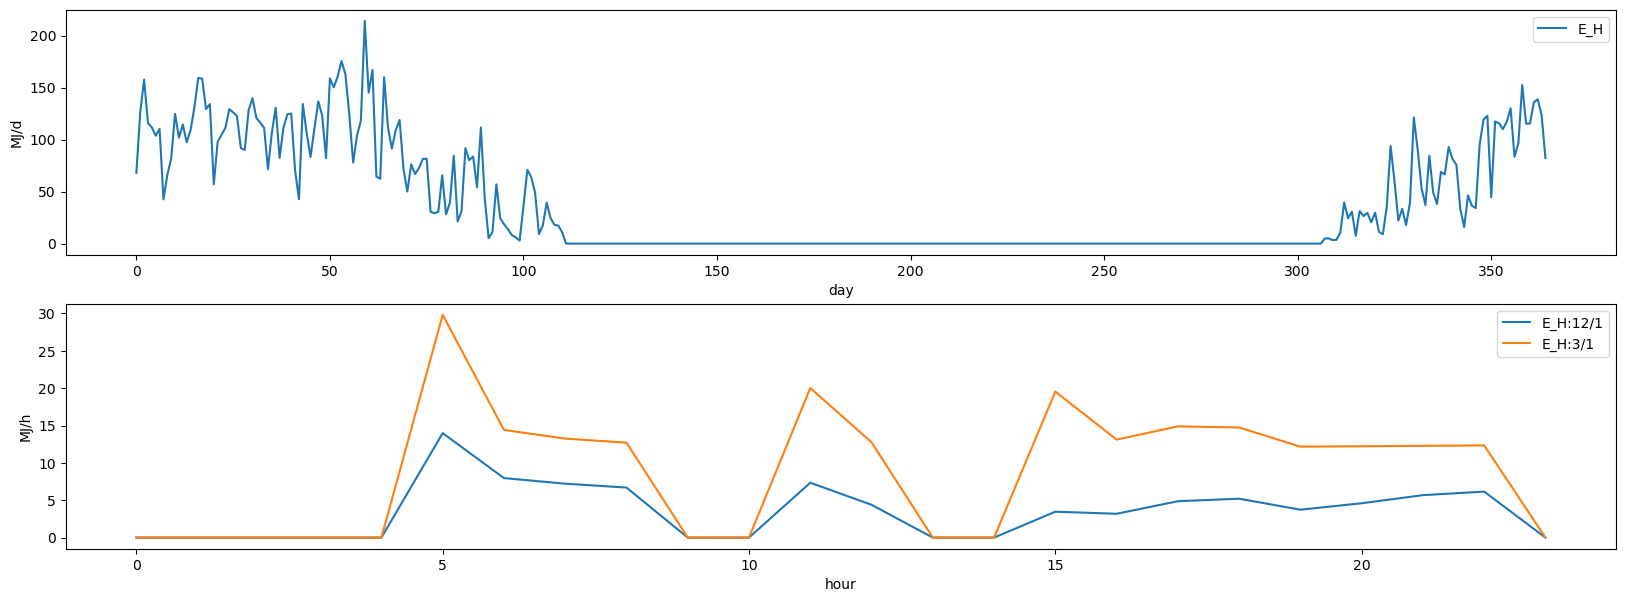

In [6]:
get_each_graph(E_H_d_t_1)

### 計算条件2

- 敷設率を0.3、仮想床の床面積を除いた敷設率を0.5に変更

In [7]:
house_base, house_ENV, H_MR, H_OR, i = get_default_hot_water_floor_heating_with_rac()
H_MR['r_Af'] = 0.3
H_MR['r_dash_Af'] = 0.5
E_H_d_t_2 = calc_results(house_base, house_ENV, H_MR, H_OR, i)

E_H_d_t(i=1)=12991.878183013943MJ/a


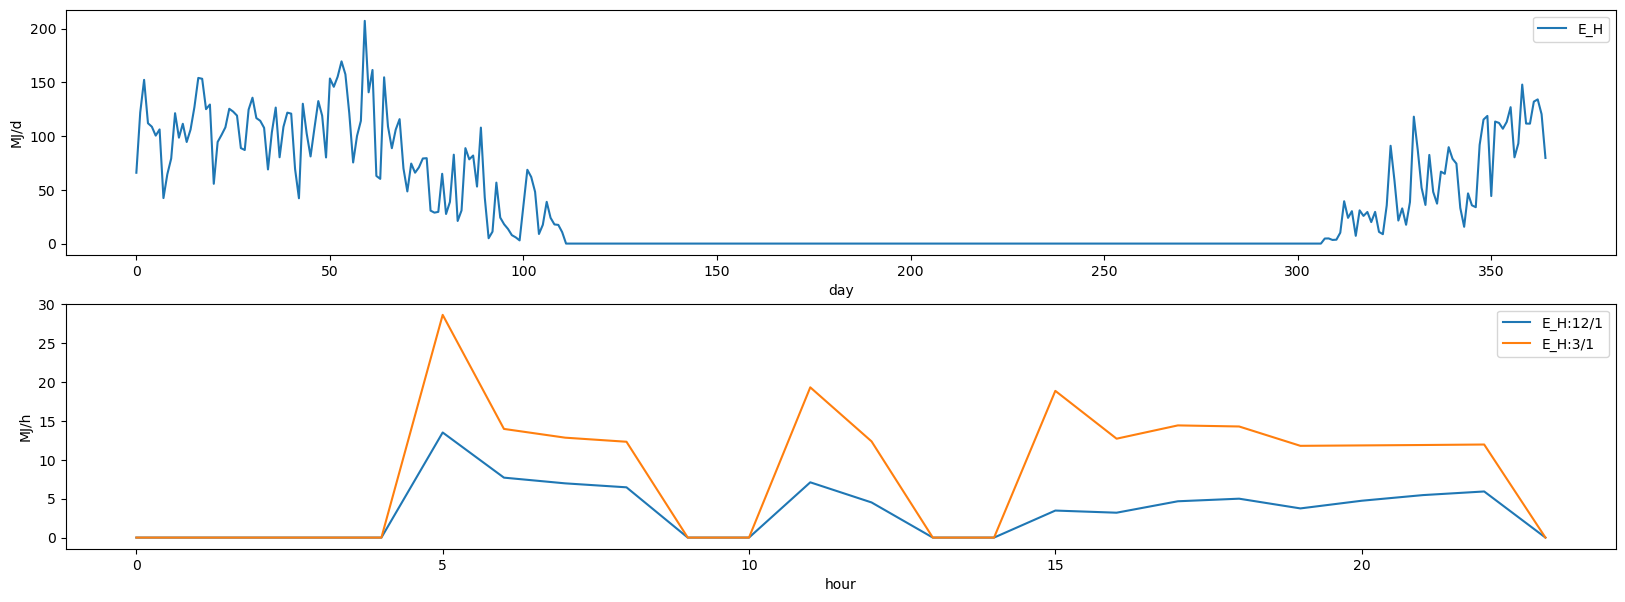

In [8]:
get_each_graph(E_H_d_t_2)

### 計算条件3

- 上面放熱率（床の断熱）を0.95に変更

In [9]:
house_base, house_ENV, H_MR, H_OR, i = get_default_hot_water_floor_heating_with_rac()
H_MR['r_up'] = 0.95
E_H_d_t_3 = calc_results(house_base, house_ENV, H_MR, H_OR, i)

E_H_d_t(i=1)=12361.117120496177MJ/a


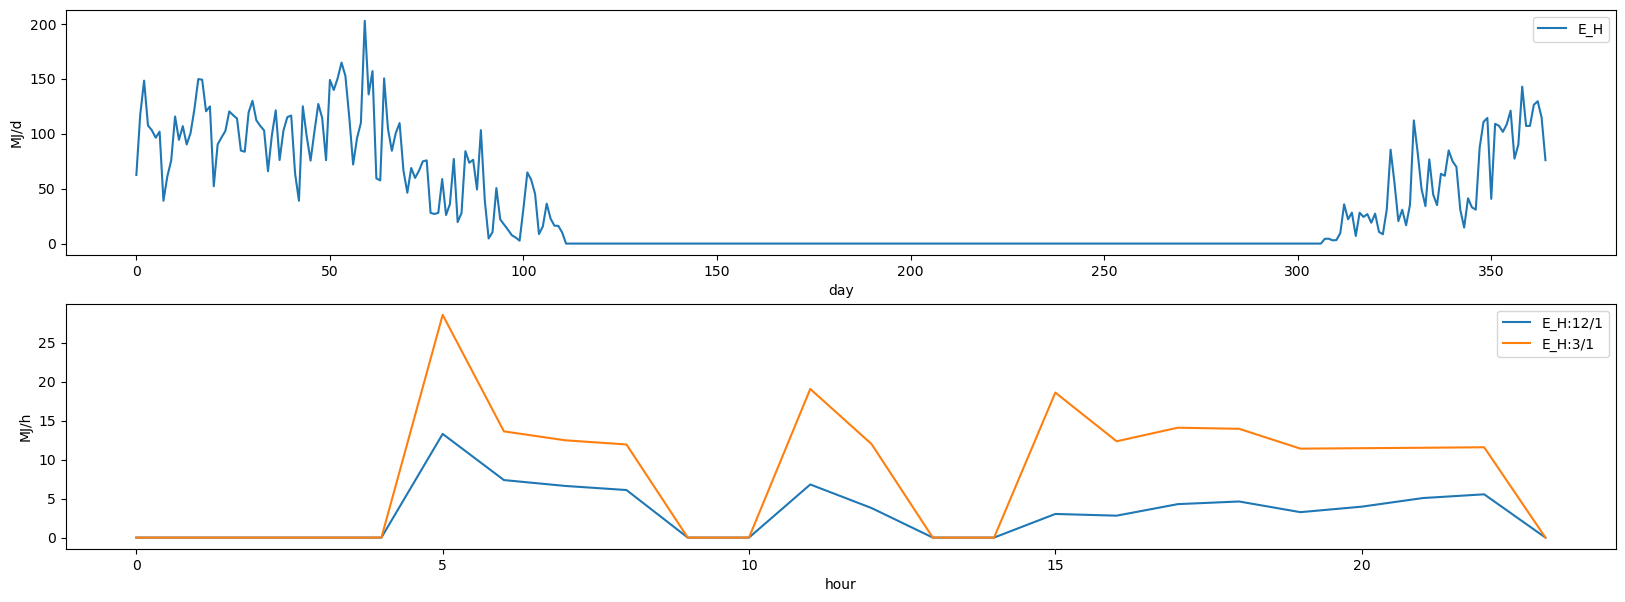

In [10]:
get_each_graph(E_H_d_t_3)

### 計算条件4

- その他居室の敷設率を0.3、上面放熱率（床の断熱）を0.95、配管断熱を採用するに変更
- 暖冷房区画を5に変更

In [11]:
house_base, house_ENV, H_MR, H_OR, i = get_default_hot_water_floor_heating_with_rac()
H_OR['r_Af'] = 0.3
H_OR['r_up'] = 0.95
H_OR['pipe_insulation'] = True
i = 5
E_H_d_t_4 = calc_results(house_base, house_ENV, H_MR, H_OR, i)

E_H_d_t(i=5)=2613.2175721644126MJ/a


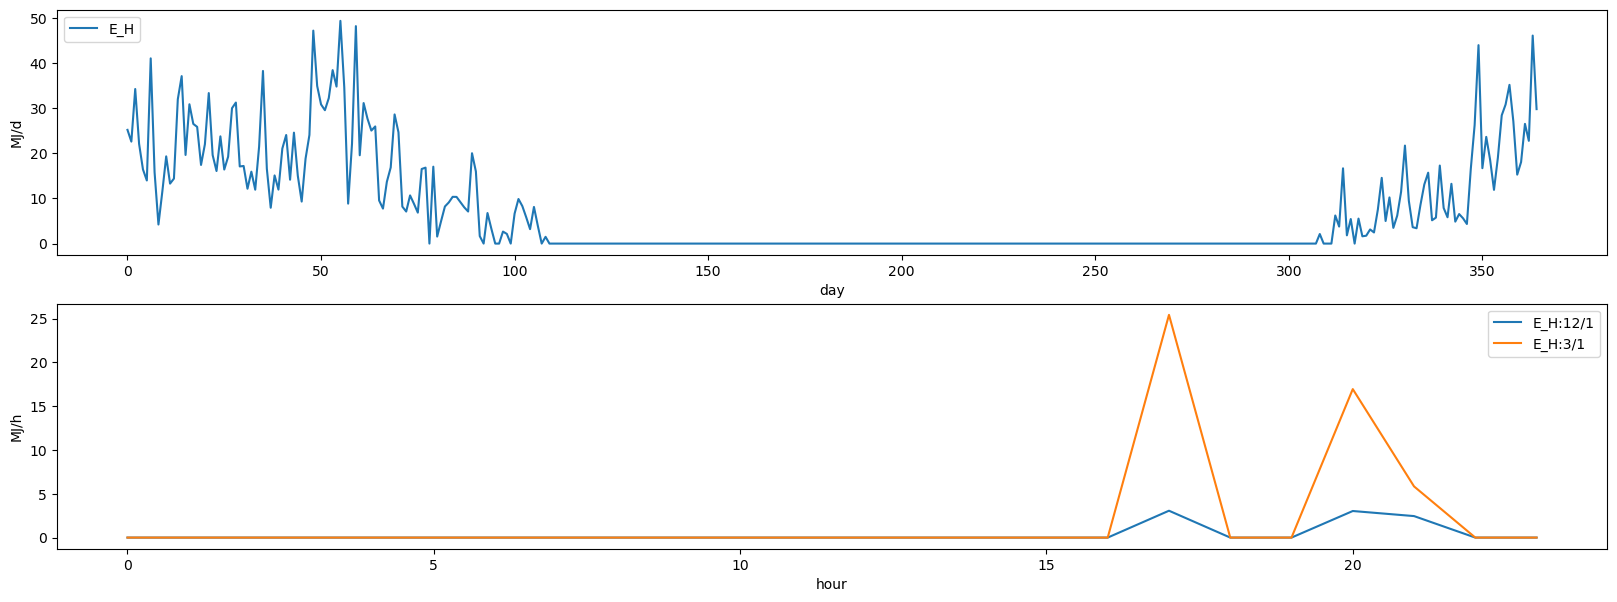

In [12]:
get_each_graph(E_H_d_t_4)

### 比較

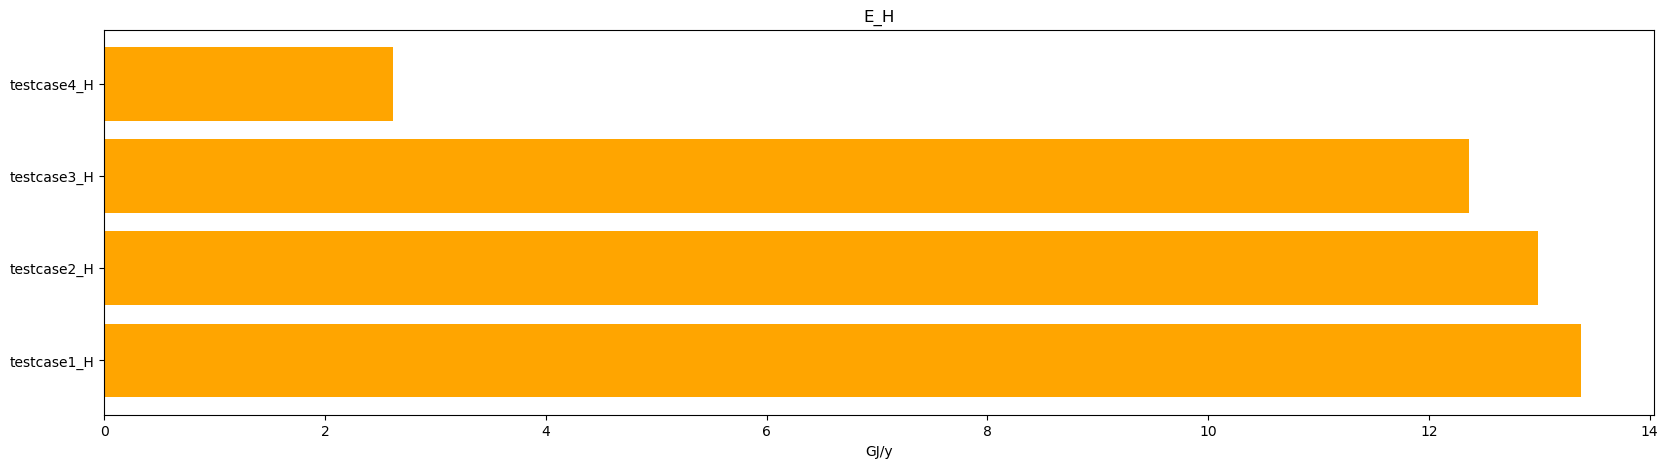

In [13]:
import matplotlib.pyplot as plt

dat_H = {"testcase1_H": np.sum(E_H_d_t_1)/1000, "testcase2_H": np.sum(E_H_d_t_2)/1000, "testcase3_H": np.sum(E_H_d_t_3)/1000, 
         "testcase4_H": np.sum(E_H_d_t_4)/1000}

x_H = list(dat_H.keys())
y_H = list(dat_H.values())

fig = plt.figure(figsize=(20,5))

grh_H = fig.add_subplot(111)
grh_H.barh(x_H,y_H, color = "orange")
grh_H.set_xlabel("GJ/y")
grh_H.set_title("E_H")

plt.show()